# Tutorial: Crypto Premium Regime Gating Final Report

This notebook is the final storytelling surface for the hiring project.
It demonstrates:

- Stablecoin debiasing (`BTCUSDC` vs `BTCUSDT` synthetic premium)
- Robust filtering + regime gating + optional Hawkes contagion gating
- Dedicated on-chain validation feed (DefiLlama stablecoin prices)
- Ablation ladder (`debias_only`, `+robust`, `+regime`, `+hawkes`)


## 1. Setup


In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

def find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / '.git').exists():
            return candidate
    return start

ROOT = find_repo_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.pipeline import load_config, load_price_matrix, run_pipeline


## 2. Episode Inventory and Metrics Snapshot


In [2]:
EPISODES = {
    'bybit_usdc_depeg_2023': 'Bybit spot - USDC depeg (2023-03-10 to 2023-03-11)',
    'okx_usdc_depeg_2023': 'OKX futures - USDC depeg (2023-03-10 to 2023-03-11)',
    'yen_unwind_2024_binance': 'Binance futures - Yen unwind (2024-08-05 to 2024-08-06)',
    'yen_followthrough_2024_binance': 'Binance futures - Follow-through (2024-08-07 to 2024-08-08)',
    'march_vol_2024_binance': 'Binance futures - March volatility (2024-03-12 to 2024-03-13)',
}

rows = []
for episode_id, label in EPISODES.items():
    metrics_path = ROOT / 'reports' / 'episodes' / episode_id / 'tables' / 'metrics.csv'
    if not metrics_path.exists():
        continue
    metrics = pd.read_csv(metrics_path, index_col=0)
    for variant in ['naive', 'gated']:
        if variant not in metrics.index:
            continue
        row = metrics.loc[variant].to_dict()
        row['episode'] = episode_id
        row['label'] = label
        row['variant'] = variant
        rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df = summary_df[['episode', 'label', 'variant', 'sharpe', 'pnl_net', 'max_drawdown', 'turnover', 'flip_rate', 'active_ratio']]
summary_df.sort_values(['episode', 'variant'])


,episode,label,variant,sharpe,pnl_net,max_drawdown,turnover,flip_rate,active_ratio
1,bybit_usdc_depeg_2023,Bybit spot - USDC depeg (2023-03-10 to 2023-03...,gated,0.000000,0.000000,0.000000,0.0,0.005208,0.000000
0,bybit_usdc_depeg_2023,Bybit spot - USDC depeg (2023-03-10 to 2023-03...,naive,-0.010127,-0.038098,-0.146418,5.0,0.002431,0.547569
9,march_vol_2024_binance,Binance futures - March volatility (2024-03-12...,gated,-0.008120,-0.001158,-0.001573,28.0,0.012500,0.111111
8,march_vol_2024_binance,Binance futures - March volatility (2024-03-12...,naive,-0.022190,-0.002353,-0.003163,72.0,0.040972,0.077778
3,okx_usdc_depeg_2023,OKX futures - USDC depeg (2023-03-10 to 2023-0...,gated,-0.006167,-0.000850,-0.001472,2.0,0.003125,0.001736
2,okx_usdc_depeg_2023,OKX futures - USDC depeg (2023-03-10 to 2023-0...,naive,0.049248,0.254991,-0.125934,381.0,0.161806,0.376389
7,yen_followthrough_2024_binance,Binance futures - Follow-through (2024-08-07 t...,gated,0.000271,0.000045,-0.000809,20.0,0.008681,0.182986
6,yen_followthrough_2024_binance,Binance futures - Follow-through (2024-08-07 t...,naive,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,yen_unwind_2024_binance,Binance futures - Yen unwind (2024-08-05 to 20...,gated,-0.003271,-0.000791,-0.002133,40.0,0.017014,0.205208
4,yen_unwind_2024_binance,Binance futures - Yen unwind (2024-08-05 to 20...,naive,0.019503,0.029486,-0.000691,10.0,0.004167,0.013889


## 3. On-Chain Validation Layer

`onchain_proxy` comes from DefiLlama stablecoin price history (`tether` vs `usd-coin`) and is compared to market-implied `stablecoin_proxy`.

Key diagnostics:
- `onchain_proxy`
- `onchain_divergence = stablecoin_proxy - onchain_proxy`
- `onchain_depeg_flag`


### Proxy Availability & Interpretation Notes

- Debiased premium `p` is most informative on episodes where cross-asset USDC/USDT proxy pairs are available (typical Binance perp windows).
- For episodes with limited cross-asset coverage, this project uses fail-closed defaults (`premium.fail_on_missing_proxy: true`) and skips incompatible windows in multi-episode reports.
- If fail-closed is intentionally disabled for diagnostics, interpret those runs primarily as depeg safety/on-chain validation checks rather than full debiased-premium demonstrations.



In [3]:
def plot_onchain_episode(episode_id: str, title: str):
    signal_path = ROOT / 'reports' / 'episodes' / episode_id / 'tables' / 'signal_frame.csv'
    if not signal_path.exists():
        print(f'Missing signal frame for {episode_id}: {signal_path}')
        return

    frame = pd.read_csv(signal_path)
    frame['timestamp_utc'] = pd.to_datetime(frame['timestamp_utc'], utc=True, errors='coerce')
    frame = frame.set_index('timestamp_utc').sort_index()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    axes[0].plot(frame.index, frame['stablecoin_proxy'], label='stablecoin_proxy (market-implied)', color='#003f5c')
    if 'onchain_proxy' in frame.columns:
        axes[0].plot(frame.index, frame['onchain_proxy'], label='onchain_proxy (DefiLlama)', color='#bc5090', alpha=0.8)
    axes[0].set_title(title)
    axes[0].set_ylabel('log(USDT/USDC)')
    axes[0].legend(loc='best')
    axes[0].grid(alpha=0.2)

    if 'onchain_divergence' in frame.columns:
        axes[1].plot(frame.index, frame['onchain_divergence'], color='#ff7f0e', label='onchain_divergence')
    if 'onchain_depeg_flag' in frame.columns:
        flag = frame['onchain_depeg_flag'].fillna(False)
        axes[1].fill_between(frame.index, -0.01, 0.01, where=flag, color='#d62728', alpha=0.10, label='onchain_depeg_flag')
    axes[1].set_ylabel('divergence')
    axes[1].set_xlabel('timestamp_utc')
    axes[1].legend(loc='best')
    axes[1].grid(alpha=0.2)

    plt.tight_layout()
    plt.show()


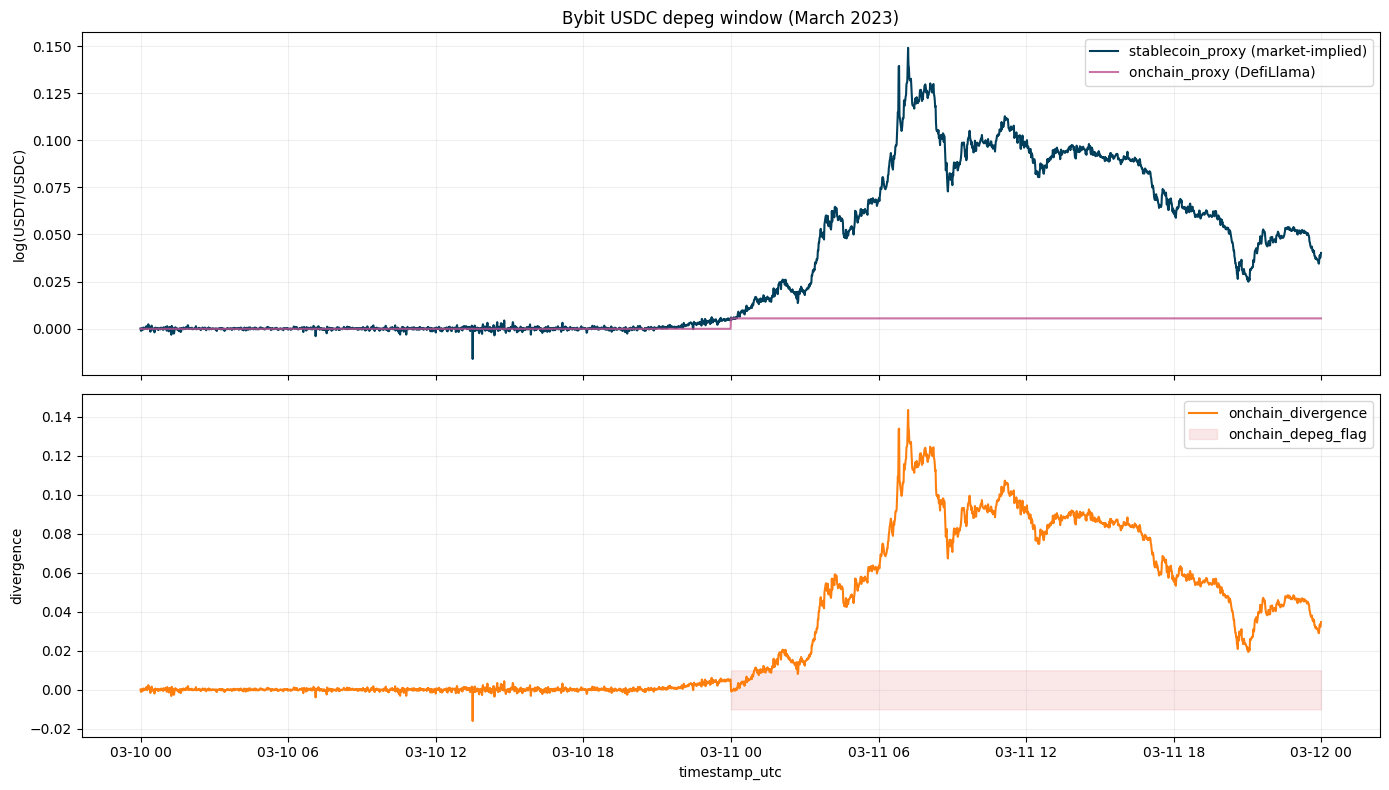

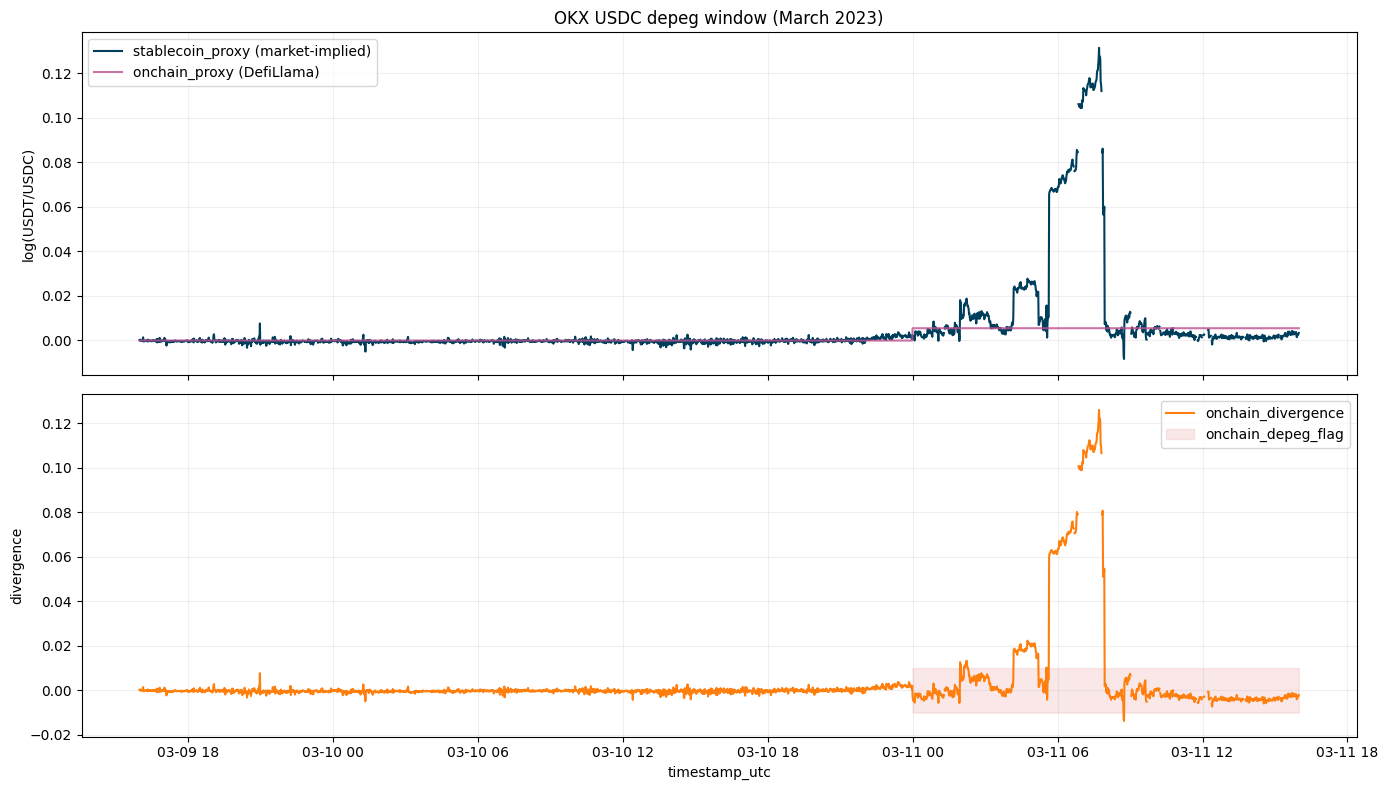

In [4]:
plot_onchain_episode('bybit_usdc_depeg_2023', 'Bybit USDC depeg window (March 2023)')
plot_onchain_episode('okx_usdc_depeg_2023', 'OKX USDC depeg window (March 2023)')


## 4. Ablation Ladder (Automated)

Expected variants:

- `naive`
- `debias_only`
- `plus_robust`
- `plus_regime`
- `plus_hawkes`

You can regenerate with:

`python -m src.ablation_report --price-matrix <matrix_path> --output-dir reports/tables`


In [5]:
ablation_path = ROOT / 'reports' / 'tables' / 'ablation_metrics.csv'
if ablation_path.exists():
    ablation_df = pd.read_csv(ablation_path, index_col=0)
    display(ablation_df)
else:
    print('No ablation_metrics.csv found yet. Run src.ablation_report first.')


,sharpe,sharpe_full_annualized,sharpe_active,sharpe_active_annualized,max_drawdown,turnover,pnl_net,flip_rate,hit_rate,active_ratio,position_flip_rate,avg_holding_bars,n_bars,n_active_bars,horizon_days,annualization_factor
variant,,,,,,,,,,,,,,,,
naive,0.019503,14.144315,0.170704,123.799559,-0.000691,10.0,0.029486,0.004167,0.550000,0.013889,0.003472,7.600000,2880,40,1.999306,725.230998
debias_only,0.020464,14.841006,0.427590,310.101782,-0.000459,8.0,0.031339,0.002778,0.875000,0.002778,0.002778,2.250000,2880,8,1.999306,725.230998
plus_robust,-0.002155,-1.562957,0.005433,3.939830,-0.002294,32.0,-0.000701,0.013194,0.478667,0.260417,0.011111,75.154667,2880,750,1.999306,725.230998
plus_regime,-0.003271,-2.372238,0.011086,8.040071,-0.002133,40.0,-0.000791,0.017014,0.492386,0.205208,0.013889,38.543147,2880,591,1.999306,725.230998
plus_hawkes,-0.000696,-0.505090,0.011417,8.279909,-0.001996,26.0,-0.000162,0.011111,0.485822,0.183681,0.009028,42.111531,2880,529,1.999306,725.230998


## 5. Gating Parameter Tuning Results (2024 episodes)


In [6]:
tuning_files = sorted((ROOT / 'reports' / 'tables').glob('gating_tuning_*.csv'))
if tuning_files:
    latest = tuning_files[-1]
    tuning_df = pd.read_csv(latest)
    print('Latest tuning file:', latest)
    display(tuning_df.head(15))
else:
    print('No tuning output found. Run src.tune_gating first.')


Latest tuning file: /Users/hugolemonnier/Desktop/Coding Project/Crypto-Premium-Regime-Gating/reports/tables/gating_tuning_oos_latest.csv


,entry_k,t_widen_quantile,chi_widen_quantile,stress_quantile,recovery_quantile,selection_score,train_n_episodes,train_score,train_mean_sharpe_full_raw,train_std_sharpe_full_raw,...,train_mean_active_ratio,train_mean_turnover,oos_n_episodes,oos_score,oos_mean_sharpe_full_raw,oos_std_sharpe_full_raw,oos_min_sharpe_full_raw,oos_mean_pnl_net,oos_mean_active_ratio,oos_mean_turnover
0,1.0,0.97,0.99,0.95,0.6,-0.014638,2.0,-0.030666,-0.005696,0.002425,...,0.158160,34.0,1.0,0.001391,0.000271,0.0,0.000271,0.000045,0.182986,20.0
1,1.0,0.97,0.99,0.99,0.6,-0.014638,2.0,-0.030666,-0.005696,0.002425,...,0.158160,34.0,1.0,0.001391,0.000271,0.0,0.000271,0.000045,0.182986,20.0
2,1.0,0.99,0.99,0.95,0.6,-0.014638,2.0,-0.030666,-0.005696,0.002425,...,0.158160,34.0,1.0,0.001391,0.000271,0.0,0.000271,0.000045,0.182986,20.0
3,1.0,0.99,0.99,0.99,0.6,-0.014638,2.0,-0.030666,-0.005696,0.002425,...,0.158160,34.0,1.0,0.001391,0.000271,0.0,0.000271,0.000045,0.182986,20.0
4,1.0,0.97,0.97,0.95,0.6,-0.017618,2.0,-0.033366,-0.006095,0.002026,...,0.157986,34.0,1.0,-0.001869,-0.000366,0.0,-0.000366,-0.000060,0.179861,20.0
5,1.0,0.97,0.97,0.99,0.6,-0.017618,2.0,-0.033366,-0.006095,0.002026,...,0.157986,34.0,1.0,-0.001869,-0.000366,0.0,-0.000366,-0.000060,0.179861,20.0
6,1.0,0.99,0.97,0.95,0.6,-0.017618,2.0,-0.033366,-0.006095,0.002026,...,0.157986,34.0,1.0,-0.001869,-0.000366,0.0,-0.000366,-0.000060,0.179861,20.0
7,1.0,0.99,0.97,0.99,0.6,-0.017618,2.0,-0.033366,-0.006095,0.002026,...,0.157986,34.0,1.0,-0.001869,-0.000366,0.0,-0.000366,-0.000060,0.179861,20.0
8,0.5,0.99,0.99,0.95,0.6,-0.017998,2.0,0.002438,0.000435,0.001279,...,0.475174,58.0,1.0,-0.038433,-0.005431,0.0,-0.005431,-0.001320,0.365278,50.0
9,0.5,0.99,0.99,0.99,0.6,-0.017998,2.0,0.002438,0.000435,0.001279,...,0.475174,58.0,1.0,-0.038433,-0.005431,0.0,-0.005431,-0.001320,0.365278,50.0


## 6. Figure Gallery (Latest Episode Exports)


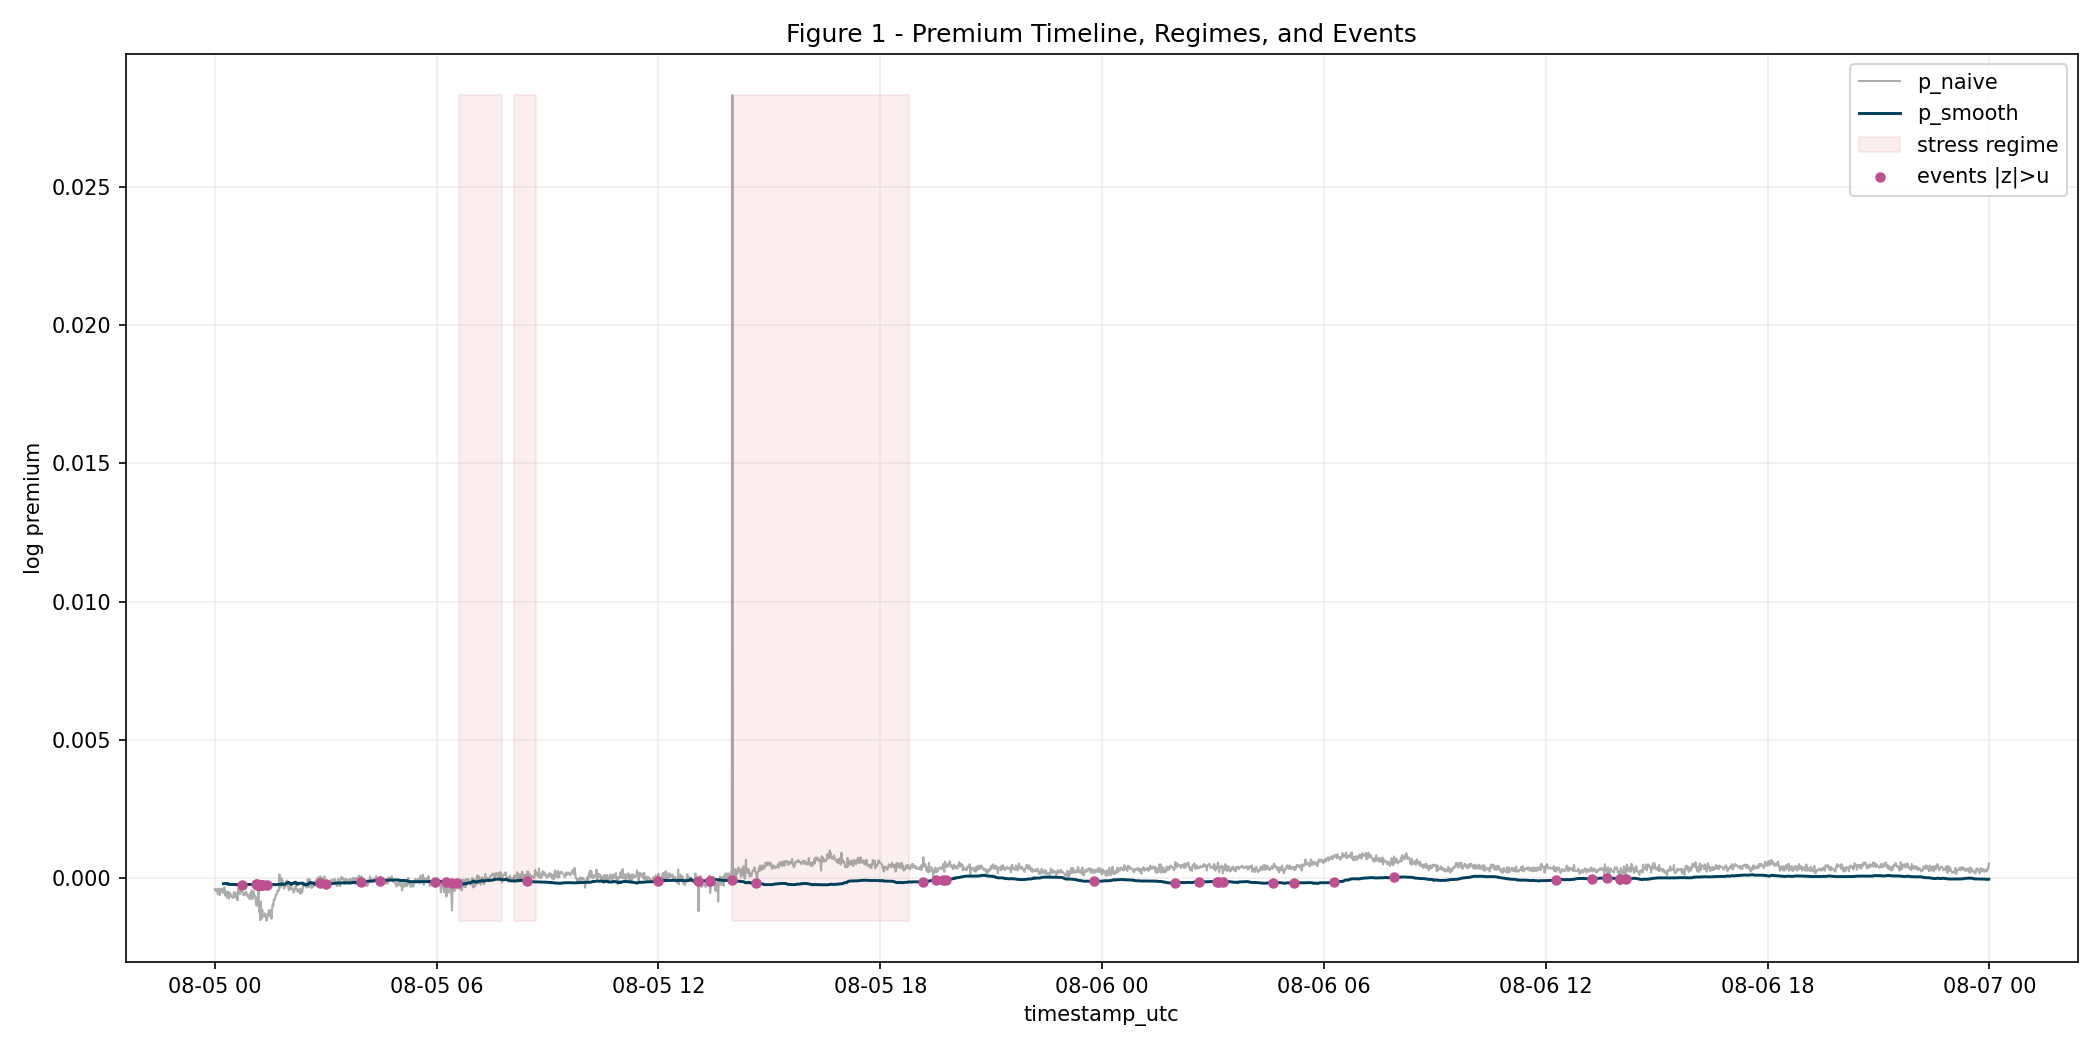

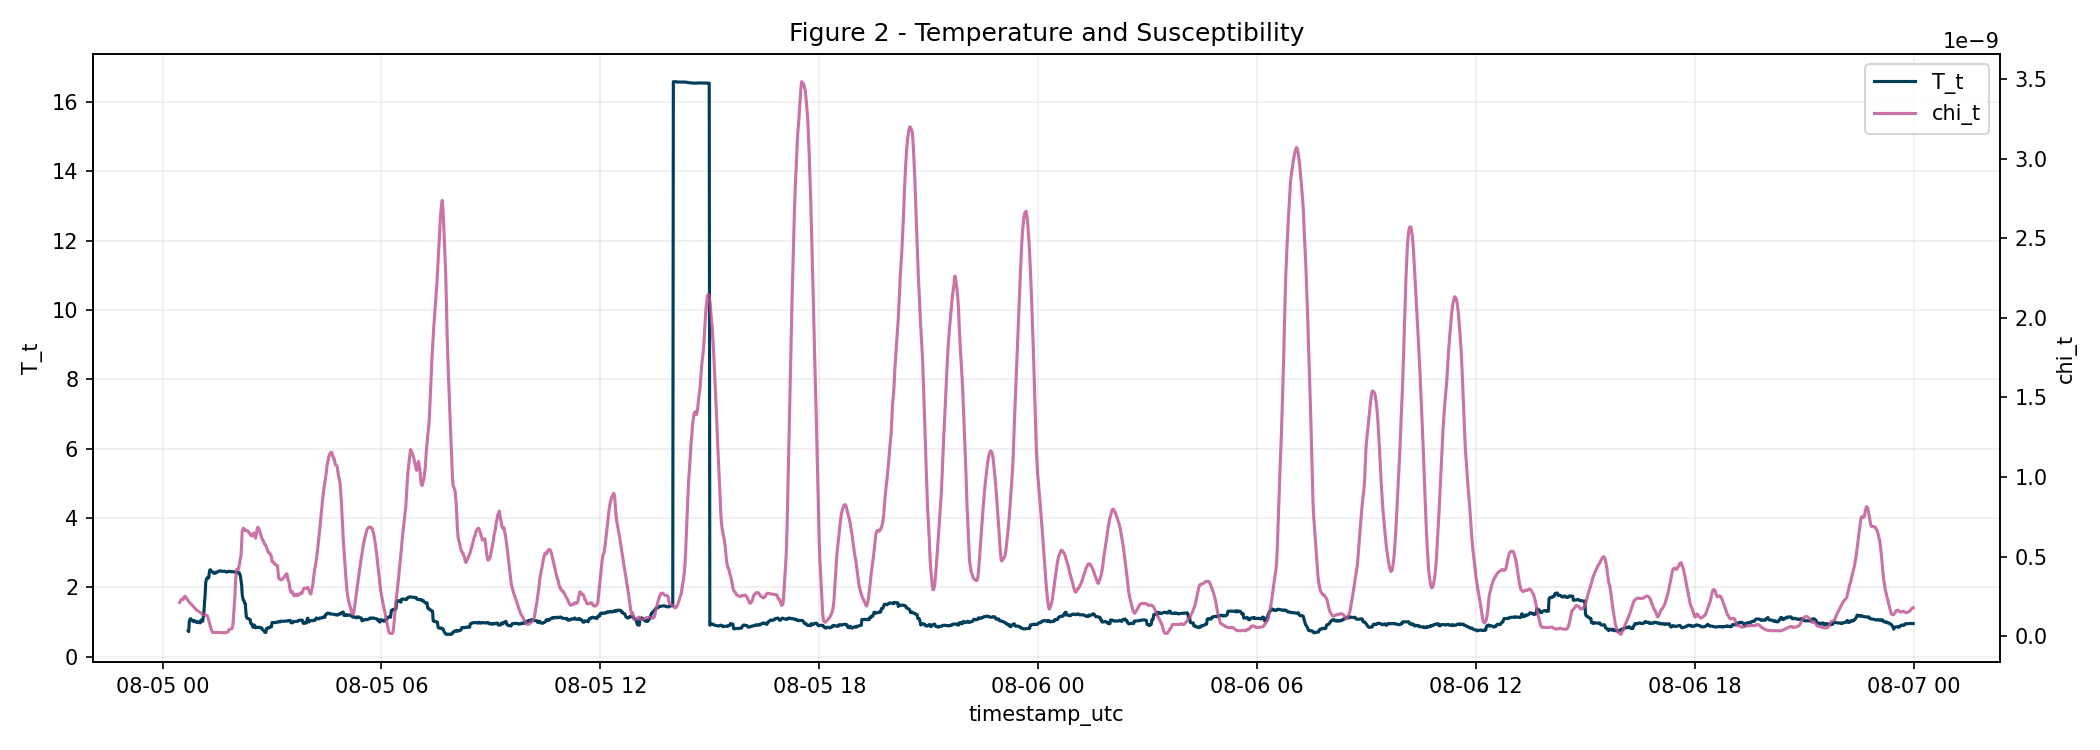

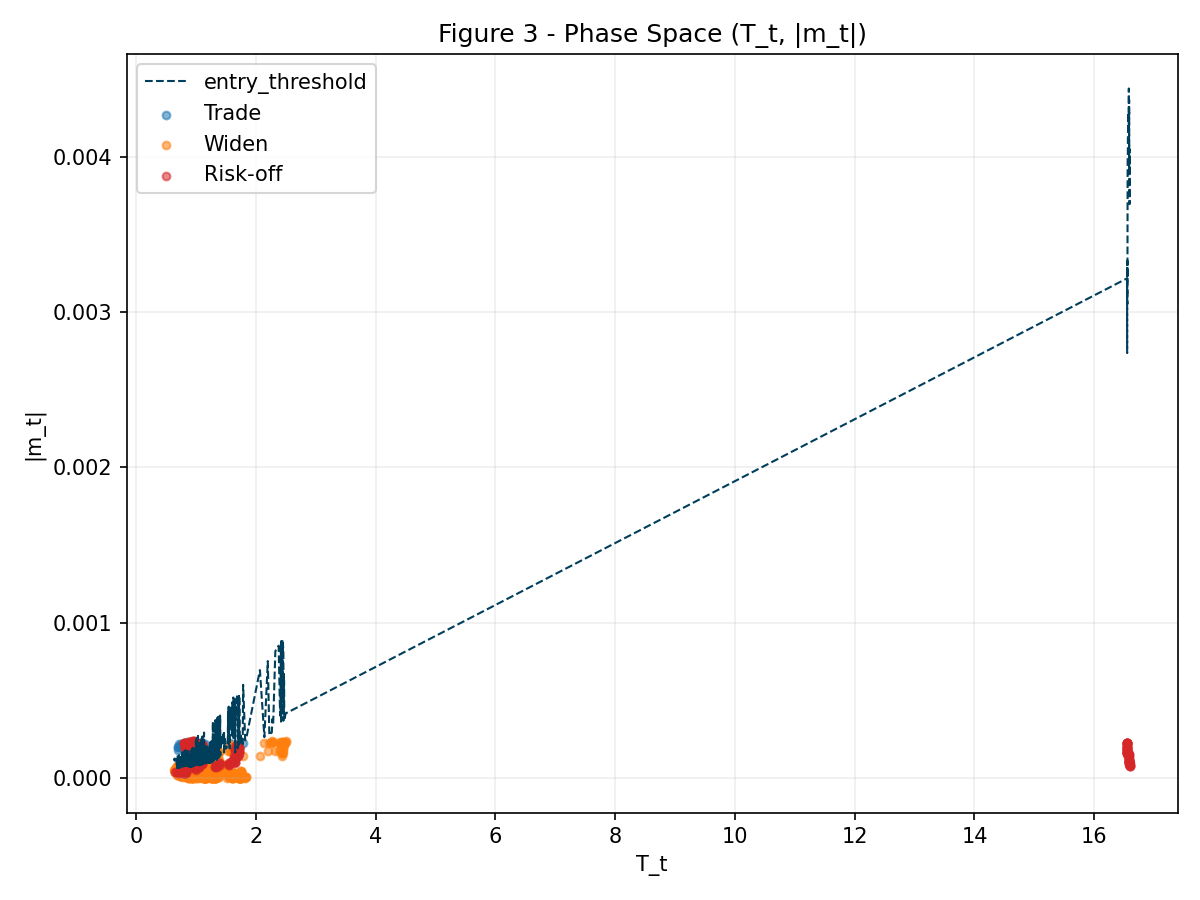

In [7]:
def show_episode_figures(episode_id: str):
    fig_dir = ROOT / 'reports' / 'episodes' / episode_id / 'figures'
    if not fig_dir.exists():
        print(f'Missing figure folder: {fig_dir}')
        return
    for name in ['figure_1_timeline.png', 'figure_2_panel.png', 'figure_3_phase_space.png']:
        p = fig_dir / name
        if p.exists():
            display(Image(filename=str(p)))
        else:
            print('Missing', p)

show_episode_figures('yen_unwind_2024_binance')


## 7. Final Checklist vs Notice + Hawkes

- [x] Debiased premium and depeg logic
- [x] Robust filter, event process, stat-mech variables
- [x] Regime gating and decision stack
- [x] Optional Hawkes contagion gating
- [x] Dedicated on-chain validation feed integrated into pipeline
- [x] Automated ablation report script
- [x] Multi-source episode loaders (Binance, Bybit, OKX)


## 8. Final Presentation Pack

The polished artifacts generated by `src.presentation_pack` and `src.calibration_report` are loaded below.


In [8]:
final_dir = ROOT / 'reports' / 'final'
print('final_dir:', final_dir)

files = [
    'final_episode_metrics_long.csv',
    'final_episode_metrics_wide.csv',
    'final_onchain_snapshot.csv',
    'calibration_details.csv',
    'calibration_aggregate.csv',
    'executive_summary.md',
]
for f in files:
    p = final_dir / f
    print(f, '->', 'OK' if p.exists() else 'MISSING')


final_dir: /Users/hugolemonnier/Desktop/Coding Project/Crypto-Premium-Regime-Gating/reports/final
final_episode_metrics_long.csv -> OK
final_episode_metrics_wide.csv -> OK
final_onchain_snapshot.csv -> OK
calibration_details.csv -> OK
calibration_aggregate.csv -> OK
executive_summary.md -> OK


In [9]:
metrics_long = pd.read_csv(ROOT / 'reports' / 'final' / 'final_episode_metrics_long.csv')
display(metrics_long)

calib = pd.read_csv(ROOT / 'reports' / 'final' / 'calibration_details.csv')
display(calib)


,episode,variant,sharpe,pnl_net,max_drawdown,turnover,flip_rate,active_ratio,hit_rate,n_bars,n_active_bars,horizon_days,sharpe_full_annualized,sharpe_active,sharpe_active_annualized,annualization_factor
0,bybit_usdc_depeg_2023,naive,-0.010127,-0.038098,-0.146418,5.0,0.002431,0.547569,0.498415,2880,1577,1.999306,-7.344198,-0.013578,-9.847149,725.230998
1,bybit_usdc_depeg_2023,gated,0.000000,0.000000,0.000000,0.0,0.005208,0.000000,0.000000,2880,0,1.999306,0.000000,0.000000,0.000000,725.230998
2,okx_usdc_depeg_2023,naive,0.049248,0.254991,-0.125934,381.0,0.161806,0.376389,0.599631,2880,1084,1.999306,35.716358,0.086513,62.741698,725.230998
3,okx_usdc_depeg_2023,gated,-0.006167,-0.000850,-0.001472,2.0,0.003125,0.001736,0.400000,2880,5,1.999306,-4.472204,-0.131812,-95.594453,725.230998
4,march_vol_2024_binance,naive,-0.022190,-0.002353,-0.003163,72.0,0.040972,0.077778,0.508929,2880,224,1.999306,-16.092644,0.044260,32.098702,725.230998
5,march_vol_2024_binance,gated,-0.008120,-0.001158,-0.001573,28.0,0.012500,0.111111,0.503125,2880,320,1.999306,-5.889201,0.005144,3.730856,725.230998
6,yen_unwind_2024_binance,naive,0.019503,0.029486,-0.000691,10.0,0.004167,0.013889,0.550000,2880,40,1.999306,14.144315,0.170704,123.799559,725.230998
7,yen_unwind_2024_binance,gated,-0.003271,-0.000791,-0.002133,40.0,0.017014,0.205208,0.492386,2880,591,1.999306,-2.372238,0.011086,8.040071,725.230998
8,yen_followthrough_2024_binance,naive,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2880,0,1.999306,0.000000,0.000000,0.000000,725.230998
9,yen_followthrough_2024_binance,gated,0.000271,0.000045,-0.000809,20.0,0.008681,0.182986,0.504744,2880,527,1.999306,0.196519,0.014857,10.774897,725.230998


,episode,matrix_path,baseline_gated_sharpe_full_raw,tuned_gated_sharpe_full_raw,delta_gated_sharpe_full_raw,baseline_gated_pnl_net,tuned_gated_pnl_net,delta_gated_pnl_net,baseline_gated_active_ratio,tuned_gated_active_ratio
0,march_vol_2024_binance,data/processed/episodes/march_vol_2024_binance...,-0.021048,-0.008120,0.012928,-0.000541,-0.001158,-0.000617,0.005208,0.111111
1,yen_followthrough_2024_binance,data/processed/episodes/yen_followthrough_2024...,-0.010655,0.000271,0.010926,-0.000270,0.000045,0.000315,0.004514,0.182986
2,yen_unwind_2024_binance,data/processed/episodes/yen_unwind_2024_binanc...,-0.008408,-0.003271,0.005137,-0.000522,-0.000791,-0.000269,0.008333,0.205208


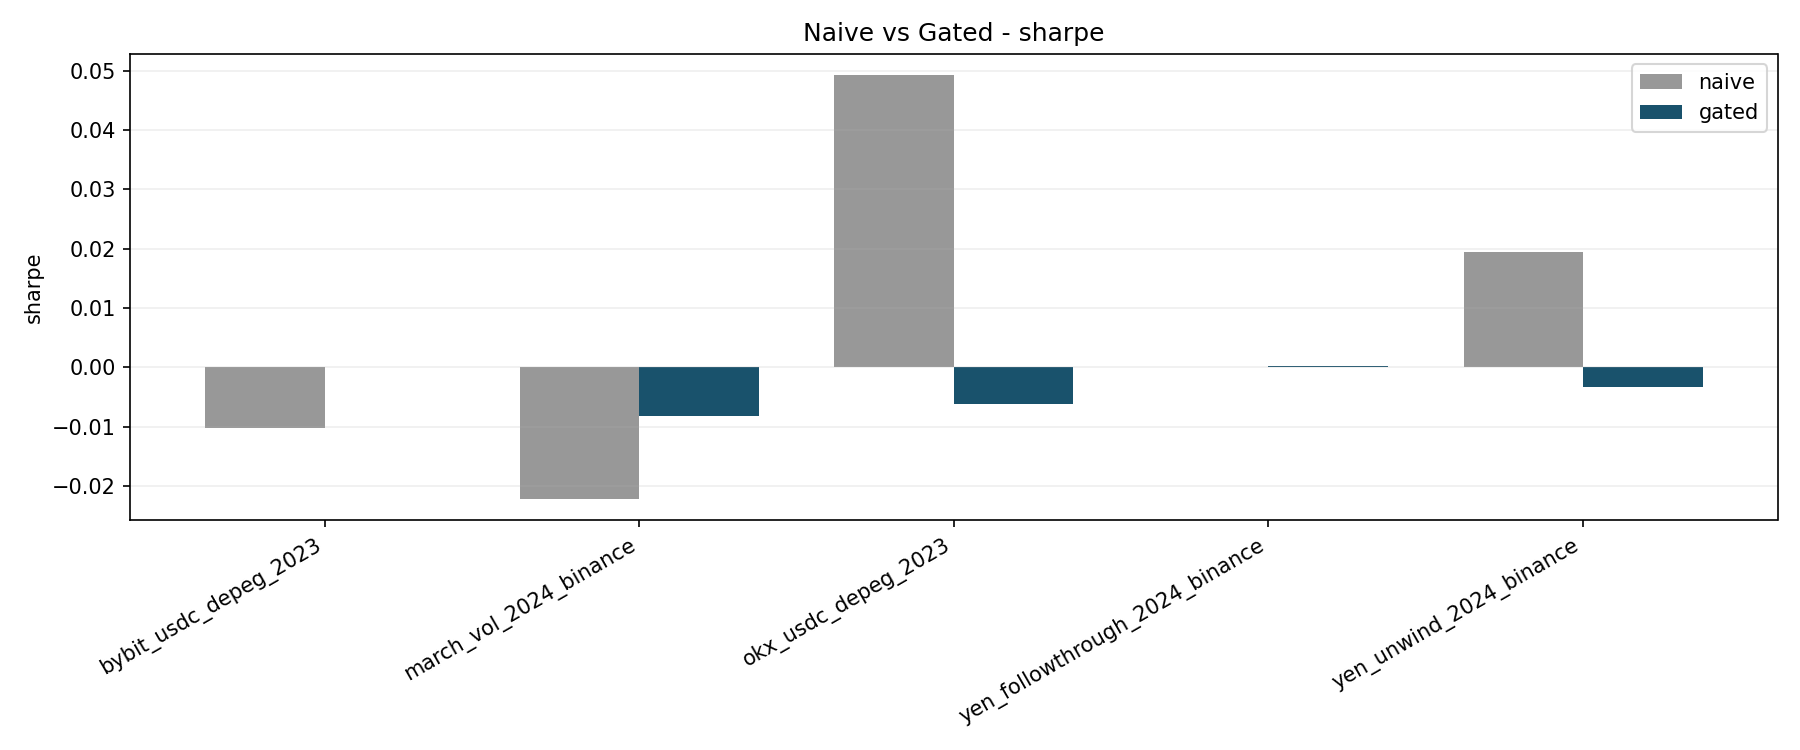

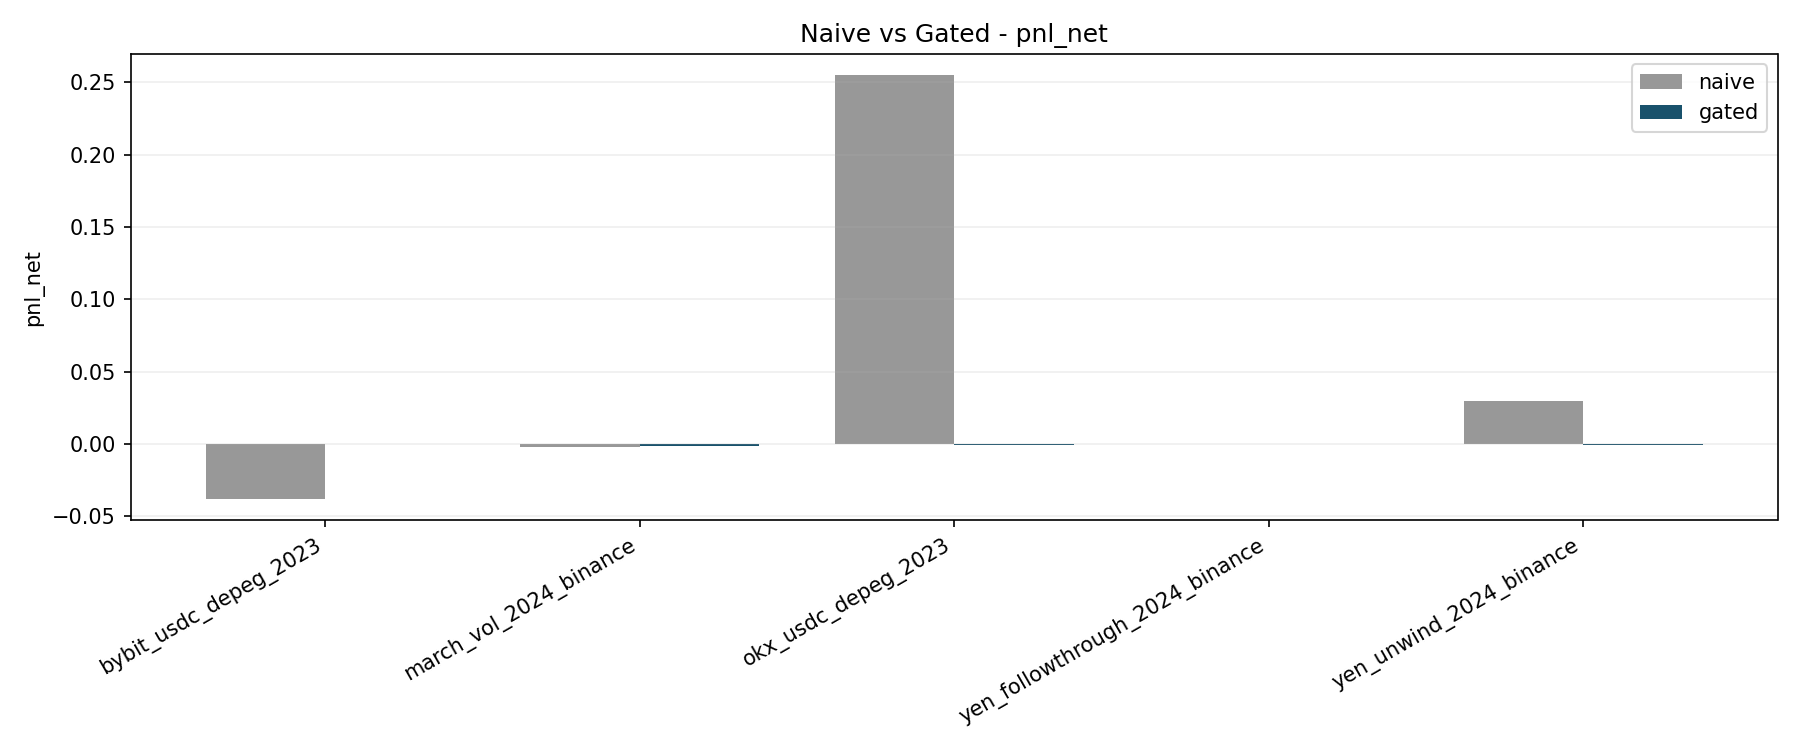

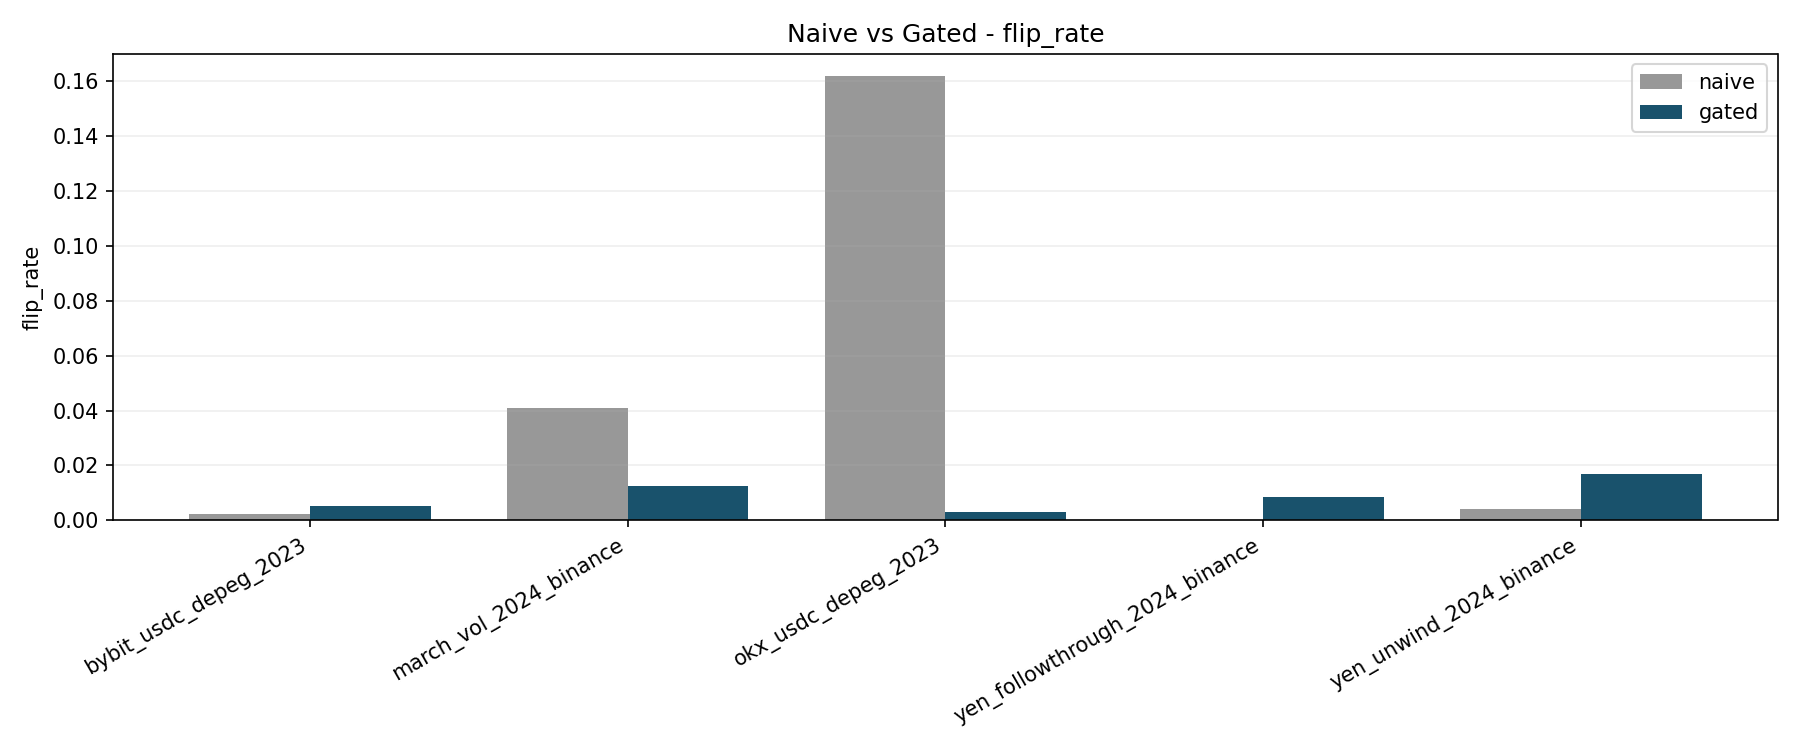

In [10]:
for fig_name in ['sharpe_naive_vs_gated.png', 'pnl_naive_vs_gated.png', 'fliprate_naive_vs_gated.png']:
    p = ROOT / 'reports' / 'final' / 'figures' / fig_name
    if p.exists():
        display(Image(filename=str(p)))


## 9. Execution Quality Diagnostics (Stablecoin Quote Markets)

This section surfaces execution-quality proxies built from bar+volume data:
- slippage proxy vs relative trade size
- cross-quote comparison (`USDC` vs `USDT`)
- resilience (recovery time after shock bars)

Artifacts are generated by:
`python -m src.execution_quality --output-dir reports/final`


In [11]:
exec_files = {
    'report': ROOT / 'reports' / 'final' / 'execution_quality_report.md',
    'slippage': ROOT / 'reports' / 'final' / 'execution_slippage_proxy.csv',
    'comparison': ROOT / 'reports' / 'final' / 'execution_cross_quote_comparison.csv',
    'resilience': ROOT / 'reports' / 'final' / 'execution_resilience.csv',
    'venue': ROOT / 'reports' / 'final' / 'execution_venue_comparison.csv',
}
for name, file_path in exec_files.items():
    print(name, '->', 'OK' if file_path.exists() else 'MISSING', file_path)

if exec_files['comparison'].exists():
    cmp = pd.read_csv(exec_files['comparison'])
    display(cmp)

if exec_files['venue'].exists():
    venue = pd.read_csv(exec_files['venue'])
    display(venue)

if exec_files['resilience'].exists():
    resilience = pd.read_csv(exec_files['resilience'])
    display(resilience.head(20))


report -> OK /Users/hugolemonnier/Desktop/Coding Project/Crypto-Premium-Regime-Gating/reports/final/execution_quality_report.md
slippage -> OK /Users/hugolemonnier/Desktop/Coding Project/Crypto-Premium-Regime-Gating/reports/final/execution_slippage_proxy.csv
comparison -> OK /Users/hugolemonnier/Desktop/Coding Project/Crypto-Premium-Regime-Gating/reports/final/execution_cross_quote_comparison.csv
resilience -> OK /Users/hugolemonnier/Desktop/Coding Project/Crypto-Premium-Regime-Gating/reports/final/execution_resilience.csv
venue -> OK /Users/hugolemonnier/Desktop/Coding Project/Crypto-Premium-Regime-Gating/reports/final/execution_venue_comparison.csv


,episode,venue,root,impact_large_mean_bps_usdc,impact_large_mean_bps_usdt,impact_large_delta_usdc_minus_usdt_bps,impact_all_mean_bps_usdc,impact_all_mean_bps_usdt,preferred_quote_on_large
0,bybit_usdc_depeg_2023,bybit,BTC,11.149728,8.167494,2.982234,8.930263,6.128325,USDT
1,bybit_usdc_depeg_2023,bybit,ETH,11.288408,10.359149,0.929259,10.101611,7.548126,USDT
2,bybit_usdc_depeg_2023,bybit,SOL,13.572481,15.171667,-1.599186,14.973906,13.630203,USDC
3,march_vol_2024_binance,binance,BNB,14.592461,15.305733,-0.713271,10.010382,10.114262,USDC
4,march_vol_2024_binance,binance,BTC,10.247856,10.653646,-0.405789,5.923007,6.021184,USDC
5,march_vol_2024_binance,binance,ETH,9.710517,10.772549,-1.062032,6.279006,6.422590,USDC
6,march_vol_2024_binance,binance,SOL,14.695266,18.394902,-3.699636,11.631011,11.671989,USDC
7,okx_usdc_depeg_2023,okx,BTC,6.426770,11.026529,-4.599759,5.634176,6.762237,USDC
8,okx_usdc_depeg_2023,okx,ETH,8.943809,12.405492,-3.461683,6.724613,7.988521,USDC
9,yen_followthrough_2024_binance,binance,BNB,10.244869,11.642265,-1.397396,8.183964,8.115851,USDC


,venue,n_root_episode_pairs,usdc_preferred_count,usdt_preferred_count,mean_delta_usdc_minus_usdt_bps,median_recovery_bars_usdc,median_recovery_bars_usdt,mean_unrecovered_ratio_usdc,mean_unrecovered_ratio_usdt
0,binance,12,11,1,-1.147746,3.0,3.5,0.0,0.002874
1,bybit,3,1,2,0.770769,2.0,2.5,0.0,0.000000
2,okx,2,2,0,-4.030721,1.0,4.0,0.0,0.000000


,episode,venue,root,quote,symbol,shock_threshold_bps,baseline_abs_ret_bps,n_shocks,n_recovered,unrecovered_ratio,recovery_median_bars,recovery_p90_bars
0,bybit_usdc_depeg_2023,bybit,BNB,USDT,BNBUSDT-SPOT,28.156058,3.650710,29,29,0.000000,2.0,8.0
1,bybit_usdc_depeg_2023,bybit,BTC,USDC,BTCUSDC-SPOT,54.668886,5.748309,29,29,0.000000,3.0,8.4
2,bybit_usdc_depeg_2023,bybit,BTC,USDT,BTCUSDT-SPOT,29.408682,4.308558,29,29,0.000000,2.0,6.6
3,bybit_usdc_depeg_2023,bybit,ETH,USDC,ETHUSDC-SPOT,62.062262,6.495326,29,29,0.000000,2.0,8.4
4,bybit_usdc_depeg_2023,bybit,ETH,USDT,ETHUSDT-SPOT,37.353090,5.345199,29,29,0.000000,3.0,9.2
5,bybit_usdc_depeg_2023,bybit,SOL,USDC,SOLUSDC-SPOT,83.483407,5.971932,29,29,0.000000,2.0,7.2
6,bybit_usdc_depeg_2023,bybit,SOL,USDT,SOLUSDT-SPOT,57.419955,11.248595,29,29,0.000000,4.0,7.6
7,march_vol_2024_binance,binance,BNB,USDC,BNBUSDC-PERP,49.556395,6.821220,29,29,0.000000,3.0,9.0
8,march_vol_2024_binance,binance,BNB,USDT,BNBUSDT-PERP,49.867023,6.874193,29,28,0.034483,4.0,11.0
9,march_vol_2024_binance,binance,BTC,USDC,BTCUSDC-PERP,32.099120,3.982542,29,29,0.000000,4.0,13.0
